# [Exploration 18] Optical Character Recognition

## Step1. 검증용 데이터셋 준비

In [1]:
import os
import matplotlib.pyplot as plt
import keras_ocr
import pytesseract
from PIL import Image
from pytesseract import Output
import cv2


In [2]:
path = os.getenv('HOME')+'/aiffel/ocr_python/test'
letters = os.listdir(path)

In [3]:
letters

['4.jpeg', '2.jpeg', '1.jpeg', '0000.png', '3.jpeg', '5.jpeg']

파일명으로 list형태로 만들어둔다,.

In [4]:
os.chdir(os.getenv('HOME')+('/aiffel/ocr_python/test'))

In [5]:
images = []
for image in letters:
    images.append(cv2.imread(image))

`plt.imread`를 사용해서도 이미지를 읽어둔다.   
이유는 잘 모르겠지만 keras-ocr을 사용할 때는 이미지를 읽은 상태로 넣어야했다.

In [13]:
images

[array([[[234, 234, 234],
         [253, 253, 253],
         [232, 232, 232],
         ...,
         [237, 237, 237],
         [237, 237, 237],
         [237, 237, 237]],
 
        [[238, 238, 238],
         [238, 238, 238],
         [244, 244, 244],
         ...,
         [237, 237, 237],
         [237, 237, 237],
         [237, 237, 237]],
 
        [[239, 239, 239],
         [230, 230, 230],
         [251, 251, 251],
         ...,
         [237, 237, 237],
         [237, 237, 237],
         [237, 237, 237]],
 
        ...,
 
        [[237, 237, 237],
         [237, 237, 237],
         [237, 237, 237],
         ...,
         [237, 237, 237],
         [237, 237, 237],
         [237, 237, 237]],
 
        [[237, 237, 237],
         [237, 237, 237],
         [237, 237, 237],
         ...,
         [237, 237, 237],
         [237, 237, 237],
         [237, 237, 237]],
 
        [[237, 237, 237],
         [237, 237, 237],
         [237, 237, 237],
         ...,
         [237, 237, 237],
  

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 1. Google OCR API

In [77]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [78]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

-rw-rw-r-- 1 aiffel-dj58 aiffel-dj58 2355  3월 16 16:17 /home/aiffel-dj58/aiffel/ocr_python/my_google_api_key.json


Google OCR API를 사용하기 위해 다음과 같이 api key를 읽어올 수 있는 있도록 한다.   
그리고 이미지에서 글자를 인식하는 `detect_text`함수를 정의한다,

Text(0.5, 1.0, '5.jpeg')

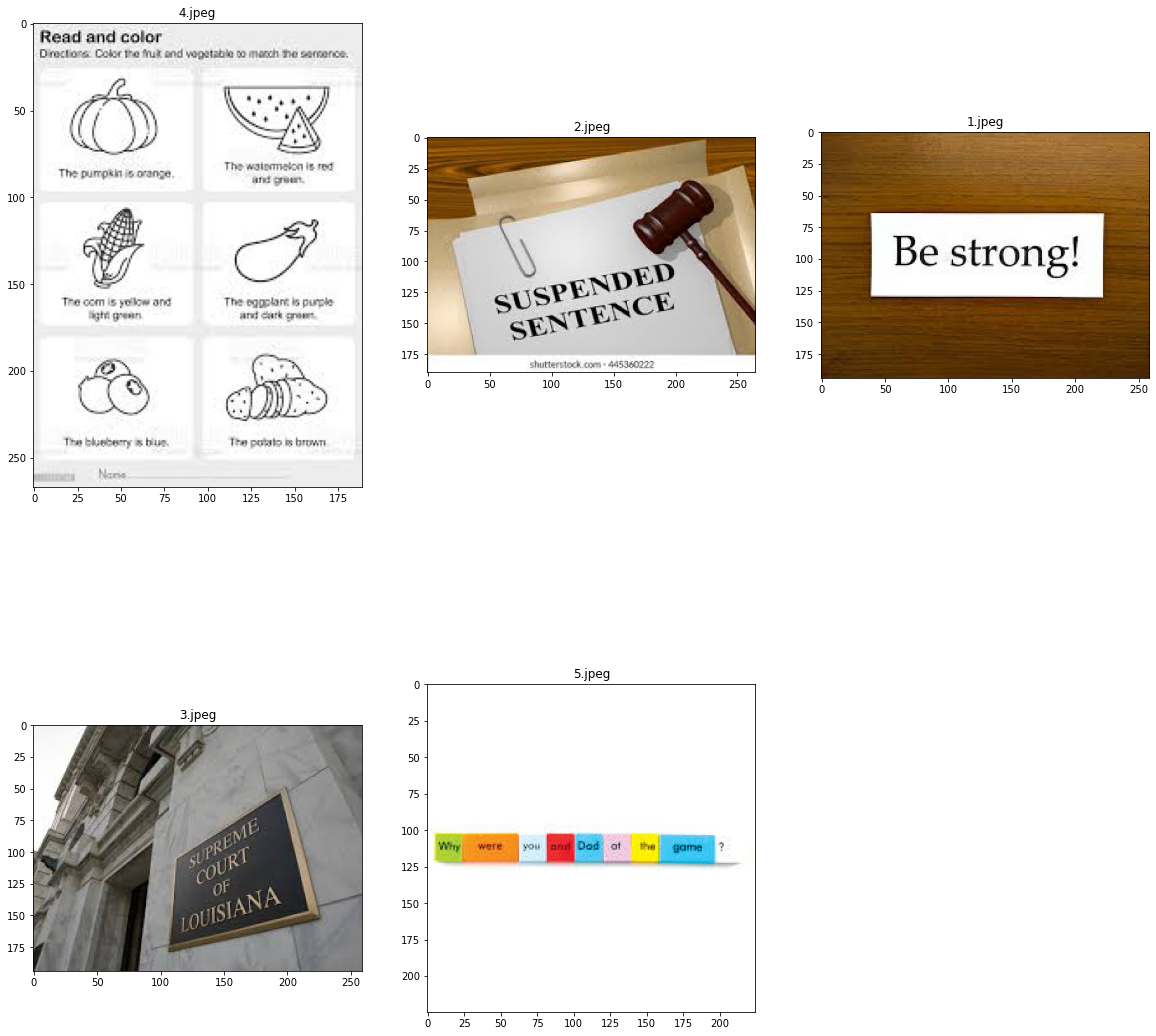

In [119]:
plt.figure(figsize=(20,20))
plt.subplot(2, 3, 2)
plt.imshow(images[1])
plt.title(letters[1])
plt.subplot(2, 3, 1)
plt.imshow(images[0])
plt.title(letters[0])
plt.subplot(2, 3, 3)
plt.imshow(images[2])
plt.title(letters[2])
plt.subplot(2, 3, 4)
plt.imshow(images[3])
plt.title(letters[3])
plt.subplot(2, 3, 5)
plt.imshow(images[4])
plt.title(letters[4])

글자가 포함된 이미지는 총 다섯개를 선정하였다.

In [52]:
for image in letters:
    detect_text(image)

Texts:

"Read and color
Directions. Color the huk and vogetable o manch hne sernence.
The watermelon is red
The pumpkin is orange.
and green.
The com is yelow and
ight grean
The eggplant is purple
and dark green
The bluebery s biun.
The potato is browI
Name
"

"Read"

"and"

"color"

"Directions."

"Color"

"the"

"huk"

"and"

"vogetable"

"o"

"manch"

"hne"

"sernence."

"The"

"watermelon"

"is"

"red"

"The"

"pumpkin"

"is"

"orange."

"and"

"green."

"The"

"com"

"is"

"yelow"

"and"

"ight"

"grean"

"The"

"eggplant"

"is"

"purple"

"and"

"dark"

"green"

"The"

"bluebery"

"s"

"biun."

"The"

"potato"

"is"

"browI"

"Name"
bounds: (35,255),(53,255),(53,266),(35,266)
Texts:

"SUSPENDED
SENTENCE
shutterstock.com - 445360222
"

"SUSPENDED"

"SENTENCE"

"shutterstock.com"

"-"

"445360222"
bounds: (146,181),(182,181),(182,187),(146,187)
Texts:

"Be strong!
"

"Be"

"strong!"
bounds: (103,78),(202,82),(201,116),(102,112)
Texts:

"SUPREME
COURT
OF
LOUISIANA
"

"SUPREME"

"COU

꽤 텍스트 인식을 잘 하는것처럼 보이지만 문제로 보이는 한가지는, Be strong!같은 경우에 be를 먼저 인식한 후 이후에 be strong이라는 글자를 한번 더 인식하고 있다.

## keras-ocr

다음으로는 keras의 ocr기능을 살펴보겠다.

In [53]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj58/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj58/.keras-ocr/crnn_kurapan.h5


In [55]:
prediction_groups = [pipeline.recognize([image]) for image in images]

In [56]:
prediction_groups

[[[('read',
    array([[ 3.,  3.],
           [29.,  3.],
           [29., 13.],
           [ 3., 13.]], dtype=float32)),
   ('and',
    array([[29.,  3.],
           [49.,  3.],
           [49., 13.],
           [29., 13.]], dtype=float32)),
   ('color',
    array([[50.,  3.],
           [75.,  3.],
           [75., 12.],
           [50., 12.]], dtype=float32)),
   ('dreclore',
    array([[ 4., 15.],
           [34., 15.],
           [34., 21.],
           [ 4., 21.]], dtype=float32)),
   ('cee',
    array([[36., 15.],
           [52., 15.],
           [52., 21.],
           [36., 21.]], dtype=float32)),
   ('rur',
    array([[63., 15.],
           [75., 15.],
           [75., 21.],
           [63., 21.]], dtype=float32)),
   ('one',
    array([[75., 15.],
           [87., 15.],
           [87., 21.],
           [75., 21.]], dtype=float32)),
   ('sosieo',
    array([[ 88.,  15.],
           [112.,  15.],
           [112.,  22.],
           [ 88.,  22.]], dtype=float32)),
   ('d',
    

Keras ocr도 글자를 잘 인식하는 것으로 보인다.   
밑에서 이미지로 확인해보겠다.

/home/aiffel-dj58/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


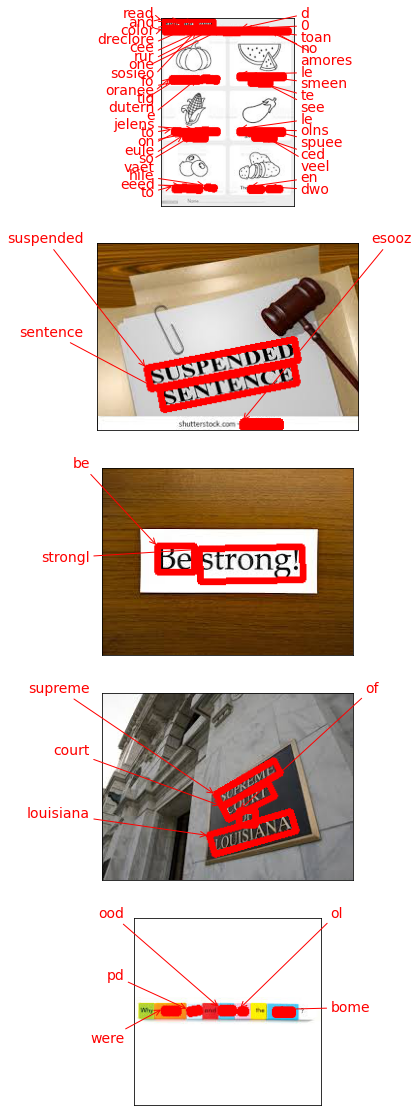

In [57]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

Be strong은 깔끔한 이미지여서 잘 인식할 줄 알았는데 이번에는 Strong에서 느낌표를 l로 인식하고 있다.

## 테서랙트 써보기

In [16]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [24]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

In [36]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [27]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [10]:
recognized_data = pytesseract.image_to_data(images[0], lang='eng', output_type=Output.DICT)

In [14]:
top_level = max(recognized_data['level'])
for i in range(len(recognized_data['level'])):
    level = recognized_data['level'][i]
    
    if level == top_level:
        left = recognized_data['left'][i]
        top = recognized_data['top'][i]
        width = recognized_data['width'][i]
        height = recognized_data['height'][i]
        print(left)

57
60
63
21
29
26
15
18
36
31
19
4
0
0


In [37]:
work_dir1 = os.getenv('HOME')+'/aiffel/ocr_python/test'
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/testt'

In [38]:
img_file_path = work_dir + '/letters.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
save_path = work_dir1

cropped_image_path_list = crop_word_regions(img_file_path, save_path)
cropped_image_path_list

/home/aiffel-dj58/aiffel/ocr_python/test/0000.png


['/home/aiffel-dj58/aiffel/ocr_python/test/0000.png']

In [21]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

4

Done


테서렉트를 사용하는 경우에는 어떤 문제에선지 전혀 글자를 인식하지 못하고 있다.

# Step3. 테스트 결과 정리

간략하게나마 각각의 테스트 결과를 정리해보자면,

#### (1) Google OCR API - 중복된 단어가 있다면 두번 인식하는 결과를 가지고 왔다. 한 단어가 여러가지 방법으로 해석되는 것을 고려하는 것은 좋지만 같은 단어를 두번 인식하게 된다면 구현 서비스의 목적에 따라 사용에 제한이 될 수 있을 것으로 생각된다.   
   
   
#### (2) keras-ocr - 케라스는 Google과 다르게 두 단어가 합쳐서 한 단어처럼 쓰이는 경우를 읽어오기 보다는 각각의 단어를 읽어오는 특징을 발견했다. 이또한 구현 목적에 따라 장점이 될 수도 있고 단점이 될 수 있을것 같다.   
   
      
      
#### (3) Tesseract - 이번 프로젝트에서 테서렉트의 OCR이 제대로 작동되지 않았고, 이유를 찾지 못했다. 노드에서 나온 결과를 분석해보자면, 한글로 분석을 했을 시에는 꽤 불안정한 결과를 보였었다.

# Step4. 결과 분석과 결론 제시

###  * 구현하고자 하는 서비스와 목적

#### 휴대폰 카메라로 글자를 비췄을 때 글자부분을 인식하고 번역해주는 서비스   
간단한 예를 들자면, 해외여행 혹은 출장시에 현지언어로 나와있는 글을 읽어야하는 경우 핸드폰에 있는 OCR기능으로 글자를 추출하고 인식한 뒤 번역을 하여 사용할 수 있음

### *평가기준

- 다양한 언어를 인식할 수 있는가?   
- 다양한 언어에 recognition이 가능한가?   
- real time으로 위 기능을 사용할 수 있는가?

### * 가장 나은 모델 제시

위 평가기준을 만족하는 모델로서는 Google OCR API가 가장 적합할 것으로 판단된다.   
이번 프로젝트에서 영어 이외에 다른 언어에 대해 시도해보진 않았지만, 리서치 자료에 의하면 Google OCR API는 다양한 언어를 인식할 수 있어 해외에 나갔을 때 스마트폰과 연동하여 글자를 인식하고 번역하여 사용하는데 가장 적합할 것이라 생각한다.

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- Tesrract를 사용했을 시에 의도했던 대로 글자를 인식하지 못해서 많은 시도가 있었다.   
- 결과적으로는 테서렉트 모델자체에서 제대로 된 글자 사진을 입력하여도 인식하지 못하는 문제로 판별되었다.


## 2. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.   
실제로 구글에서 구현되고 있는 서비스로 OCR기능을 활용한 장점이 크다.   
- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.   
가장 중요한 기준으로는 다양한 언어를 인식할 수 있는지라고 생각한다.   
- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
구글 OCR이나 케라스 OCR에서는 정상적으로 인식하는 사진의 경우 테서렉트에서 인식하지 못하는 경우가 허다하였다.   
이러한 문제를 해결하려는 시도들에 많은 시간을 허비하였다.
   
### 5. **자기 다짐**   
OCR이라는 분야에도 딥러닝이 적용될지는 생각해보지 못했는데 이번 프로젝트를 통해 OCR을 이용할 수 있는 다양한 모델을 경험해보고 직접 사용해볼 수 있어서 좋았다. 딥러닝이 사용될 수 있는 분야에 대해 더 다양하게 생각해볼 수 있을것 같다.

   